## **Multiclass Classification using ELMs and kernels** 

## **Introduction**

This tutorial demonstrates a multiclass classification using extreme learning machine (ELM) and kernel method. First, you implement ELM by using the least-square method and observe its training and testing accuracy behavior. Second, you compare it with the kernel method when using a linear kernel and investigate the importance of random weights. 

ELM is implemented using regularized least-square method. Let us use a matrix notation for convenience and denote the training samples by $\mathbf{X}=[\mathbf{x}_1, \cdots, \mathbf{x}_J] \in \mathbb{R}^{P \times J}$ and their corresponding targets by $\mathbf{T}=[\mathbf{t}_1, \cdots, \mathbf{t}_J] \in \mathbb{R}^{Q \times J}$. Here, $P$ is the input samples dimension, $Q$ is the target dimension (number of classes), and $J$ is the number of training samples. 

Training a regularized ELM consists in finding:
\begin{align}
    \mathbf{W}^{\star} = \underset{\mathbf{W}}{\arg\min} ||\mathbf{T} - \mathbf{W} \mathbf{Y}||_F^2 + \lambda ||\mathbf{W}||_F^2,
\end{align}
where $\mathbf{Y} = \mathbf{g}(\mathbf{R}\mathbf{X}+\mathbf{B}) \in \mathbb{R}^{n \times J}$ is the output of the activation function $\mathbf{g}$ and $n$ is the number of hidden neurons. Note that the weight matrix $\mathbf{R} \in \mathbb{R}^{n \times P}$ and the bias matrix $\mathbf{B}=[\mathbf{b},\cdots,\mathbf{b}] \in \mathbb{R}^{n \times J}$ are sampled from a Normal distribution and are kept fixed.

This minimization problem has the following closed-form solution:
\begin{align}
    \mathbf{W}^{\star} = \mathbf{T} \mathbf{Y}'(\mathbf{Y}\mathbf{Y}' + \lambda \mathbf{I})^{-1},
\end{align}
where $\mathbf{I} \in \mathbb{R}^{n \times n}$ is the identity matrix. The notation $\mathbf{Y}'$ denotes the transpose of the matrix $\mathbf{Y}$. 


## **Tasks**

In this notebook:

1. Complete the missing code statements to build an extreme learning machine (ELM) training framework, dependent on parameter $\lambda$ mentioned above.
2. Determine the optimal value of $\lambda$ using a grid search cross-validation scheme. Plot the validation accuracy of ELM for $\lambda = 10^{-2}, 10^{-1}, 10^{0}, \cdots, 10^{3}$ in one figure. Similarly, plot the validation accuracy versus different values of the hyper-parameter $n$.
3. What are the best values for the hyperparameters?
5. Find the testing accuracy of the linear and Gaussian kernel method when the optimal hyperparameters are used.
6. *Bonus question*: Can you provide an explanation of why the ELM with Gaussian kernels perform better than the linear kernel case?


Note: the Bonus exercises are not mandatory and will not be used as a grading criterion.



## Dataset

In this notebook, we use the Vowel dataset which contains 990 English vowel utterances. In the dataset, 15 speakers say 11 vowels 6 times each. The utterances are grouped per speaker and vowel, using integers 0-89. Each utterance is represented by ten floating-point values.
The dataset is split into a training and testing set. The training set contains data from groups 0-47 and the test groups 48-89. The goal is to predict the uttered vowel of the utterances in the test set, using information from the training set only. The performance is reported using the number of correct classifications in the test set. For more information regarding the Vowel dataset refer to [this page](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Vowel+Recognition+-+Deterding+Data))

In [1]:
# Import necessary libraries
import numpy as np
from scipy.io import loadmat
import sklearn
import matplotlib
import matplotlib.pyplot as plt

In [2]:
print("numpy=={}".format(np.__version__))
print("scikit-learn=={}".format(sklearn.__version__))
print("matplotlib=={}".format(matplotlib.__version__))

numpy==1.21.2
scikit-learn==1.0.1
matplotlib==3.4.3


In [3]:
np.random.seed(1)

# **Definition of the required functions and class**
Here, we define some of the functions that we are going to use later in this notebook.

## Preparing the dataset

In [4]:
# Define the function to load the dataset
def prepare_dataset(dataset_location="./Vowel.mat"):
    """
    An example of how the dataset looks in practice:
    +-------+--------+-------+---------+
        | vowel |  word  | vowel |  word   | 
        +-------+--------+-------+---------+
        |  i    |  heed  |  O    |  hod    |
        |  I    |  hid   |  C:   |  hoard  |
        |  E    |  head  |  U    |  hood   |
        |  A    |  had   |  u:   |  who'd  |
        |  a:   |  hard  |  3:   |  heard  |
        |  Y    |  hud   |       |         |
        +-------+--------+-------+---------+
    """
    X = loadmat(dataset_location)["featureMat"]
    Y = loadmat(dataset_location)["labelMat"]
    X_train, X_test = X[:, :528].astype(np.float32), X[:, 528:].astype(np.float32)
    Y_train, Y_test = Y[:, :528].astype(np.float32), Y[:, 528:].astype(np.float32) 
    return X_train, X_test, Y_train, Y_test

## Define a function to calculate the accuracy

In [5]:
def calculate_accuracy(S, T):
    # S: predicted
    # T: given
    Y = np.argmax(S, axis=0)
    T = np.argmax(T, axis=0)
    accuracy = np.sum([Y == T]) / Y.shape[0]
    return accuracy

## Define a class for an Extreme learning machine network

- Complete the following class definition for defining an extreme learning machine

In [6]:
class ELM(object):
    
    def __init__(self, n, lam, P):
        self.n = n
        self.lam = lam
        self.Ri = self.initialise_random_matrix(M=n, N=P)
        self.b = self.initialise_random_matrix(M=n, N=1)
        self.W_ls = None
    
    def activation_function(self, Z):
        return np.maximum(0, Z)

    def initialise_random_matrix(self, M, N):
        return np.random.uniform(low = -1, high = 1, size = (M,N)) 
        #return A - np.mean(A)
        #return np.random.normal(0, 1, size=(M, N))

    def LS(self, Y, T):
        """Solve the optimization problem as regularized least-squares"""
        P = Y.shape[0]
        W_ls = np.dot(np.dot(T,Y.T), np.linalg.inv(np.dot(Y,Y.T) + self.lam * np.eye(P))).astype(np.float32)
        return W_ls
    
    def train(self, X, T):
        
        N = X.shape[1]
        Zi = np.dot(self.Ri, X) + np.tile(self.b,(1,N))
        Yi = self.activation_function(Z=Zi)
        self.W_ls = self.LS(Y=Yi, T=T)
        #T_hat = np.dot(self.W_ls, Yi)
        #return T_hat
    
    def evaluate(self, X):
        
        N = X.shape[1]
        Zi = np.dot(self.Ri, X) + np.tile(self.b,(1,N))
        Yi = self.activation_function(Z=Zi)
        T_hat = np.dot(self.W_ls, Yi)
        return T_hat
        

## Define the training pipeline 

In [7]:
def train_ELM(X_train, T_train, X_val=None, T_val=None, n=2000, lam=1e2):
    
    elm_net = ELM(n=n, lam=lam, P=X_train.shape[0])
    elm_net.train(X=X_train, T=T_train)
    T_hat_train = elm_net.evaluate(X=X_train)
    T_hat_val = elm_net.evaluate(X=X_val)
    acc_train = calculate_accuracy(T_hat_train, T_train)
    acc_val = calculate_accuracy(T_hat_val, T_val)
    
    return acc_train, acc_val, elm_net

# **Training ELM by using least-square method**

We set the number of hidden neurons $n$ and the regularization hyperparameter $\lambda$, and construct a single layer neural network.

## Get an initial estimate of accuracy from an ELM

In [8]:
# Get the dataset
X_train_all, X_test, T_train_all, T_test = prepare_dataset(dataset_location="./Vowel.mat")

In [9]:
P= X_train_all.shape[0] # Input features
Q = T_train_all.shape[0] # Output label size
N_train = X_train_all.shape[1] # Number of samples in training data
N_test = X_test.shape[1] # Number of samples in test data

In [10]:
print(P, Q, N_train, N_test)

10 11 528 462


In [11]:
def split_tr_val_data(X, T, train_val_split=0.8):
    
    N = X.shape[1]
    indices = np.random.permutation(N)
    num_train_samples = int(train_val_split * len(indices))
    num_val_samples = len(indices) - num_train_samples
    train_indices = indices[:num_train_samples]
    val_indices = indices[num_train_samples:]
    X_train, T_train = X[:, train_indices], T[:, train_indices]
    X_val, T_val = X[:, val_indices], T[:, val_indices]
    print(X_train.shape, T_train.shape, X_val.shape, T_val.shape)
    return X_train, T_train, X_val, T_val

In [12]:
tr_to_val_split = 0.8
X_train, T_train, X_val, T_val = split_tr_val_data(X=X_train_all, T=T_train_all, train_val_split=tr_to_val_split)

(10, 422) (11, 422) (10, 106) (11, 106)


### Execute this cell to train the ELM using an arbitrary $\lambda$. 

We note that executing this cell several times can lead to different results. On average the classification accuracy is poor. 

In [13]:
acc_train_star, acc_val_star, elm_net_star = train_ELM(X_train, T_train, X_val, T_val, n=200, lam=1e-18)
T_hat_test = elm_net_star.evaluate(X=X_test)
acc_test_star = calculate_accuracy(T_hat_test, T_test)
print("Lambda: {}, Acc_train: {}, Acc_val: {}, Acc_test: {}".format(1e-20, 
                                                                  acc_train_star, 
                                                                  acc_val_star, 
                                                                  acc_test_star))

Lambda: 1e-20, Acc_train: 0.7203791469194313, Acc_val: 0.7075471698113207, Acc_test: 0.20562770562770563


## Grid search Cross Validation: Sweeping over a set of parameters $\lambda$ to find the ELM with most suited architecture
Here we want to use existing libraries for [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
This requires our ELM class to implement certain methods.

- We reimplement an `ELM_estimator` by subclassing from `BaseEstimator`
- We add standard methods to the train and evaluate the model: `fit()`, `predict()` and `score()` function. 

In [14]:
from sklearn.base import BaseEstimator

class ELM_estimator(BaseEstimator):
    
    def __init__(self, n=2000, lam=1e-5, P=10):
        super().__init__()
        self.n = n
        self.lam = lam
        self.P = P
        self.Ri = self.initialise_random_matrix(M=self.n, N=self.P)
        self.b = self.initialise_random_matrix(M=n, N=1)
        self.W_ls= None # Fitting parameters
    
    def activation_function(self, Z):
        return np.maximum(0, Z)

    def initialise_random_matrix(self, M, N):
        return np.random.uniform(low = -1, high = 1, size = (M,N)) 
        #return A - np.mean(A)
        #return np.random.normal(0, 1, size=(M, N))

    def LS(self, Y, T):
        """Solve the optimization problem as regularized least-squares"""
        P = Y.shape[0]
        W_ls = np.dot(np.dot(T,Y.T), np.linalg.inv(np.dot(Y,Y.T) + self.lam * np.eye(P))).astype(np.float32)
        return W_ls
    
    def fit(self, X, T):
        
        X, T = X.T, T.T
        N = X.shape[1]
        Zi = np.dot(self.Ri, X) + np.tile(self.b, (1,N))
        Yi = self.activation_function(Z=Zi)
        self.W_ls = self.LS(Y=Yi, T=T)
        return self
        #T_hat = np.dot(self.W_ls, Yi)
        #return T_hat
    
    def predict(self, X):
        
        X = X.T
        N = X.shape[1]
        Zi = np.dot(self.Ri, X) + np.tile(self.b,(1,N))
        Yi = self.activation_function(Z=Zi)
        T_hat = np.dot(self.W_ls, Yi)
        return T_hat
    
    def score(self, X, T):
        
        T = np.transpose(T)
        T_hat = self.predict(X)
        Y = np.argmax(T_hat, axis=0)
        T = np.argmax(T, axis=0)
        
        accuracy = np.sum([Y == T]) / Y.shape[0]
        return accuracy
        

In [15]:
np.logspace(-2, 3, 6).tolist()

[0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

In [16]:
np.linspace(10, 500, 11)

array([ 10.,  59., 108., 157., 206., 255., 304., 353., 402., 451., 500.])

In [17]:
# You can set these parameter dictionaries as you like to search over a grid of parameters
param_grid = {'lam': np.logspace(-2, 3, 6).tolist(),  
              'n': np.linspace(10, 500, 11).astype(np.int16).tolist()
             } 

### Using Grid search and k-fold cross validation.

Here, we consider $K=5$ folds as default. 

- Look up the use of `sklearn.model_selection.GridSearchCV` in the  [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

- Using `sklearn.model_selection.GridSearchCV` find the best hyperparameters `lam, n`. Use options:
    - 5 cross validation folds
    - refit in case of a new fold
    - verbosity=3 (to display progress)
    - If you have multiple cores on your machine, you can parallelize using `n_jobs`
- Display the best hyperparameters through grid search. 

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
grid = GridSearchCV(ELM_estimator(), param_grid, refit = True, cv=5, verbose =3, n_jobs=4) 

# Get the dataset
X_train_all, X_test, T_train_all, T_test = prepare_dataset(dataset_location="./Vowel.mat")

# fitting the model for grid search 
grid.fit(X_train_all.T, T_train_all.T) 

Fitting 5 folds for each of 66 candidates, totalling 330 fits


GridSearchCV(cv=5, estimator=ELM_estimator(), n_jobs=4,
             param_grid={'lam': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
                         'n': [10, 59, 108, 157, 206, 255, 304, 353, 402, 451,
                               500]},
             verbose=3)

In [20]:
# print best parameter after tuning 
print(grid.best_params_)

{'lam': 0.1, 'n': 353}


In [21]:
n_arr = np.unique(grid.cv_results_['param_n'].data)

In [22]:
np.array([[m, p['lam']] for p,m in zip(grid.cv_results_['params'],grid.cv_results_['mean_test_score']) if p['n'] == 20])

array([], dtype=float64)

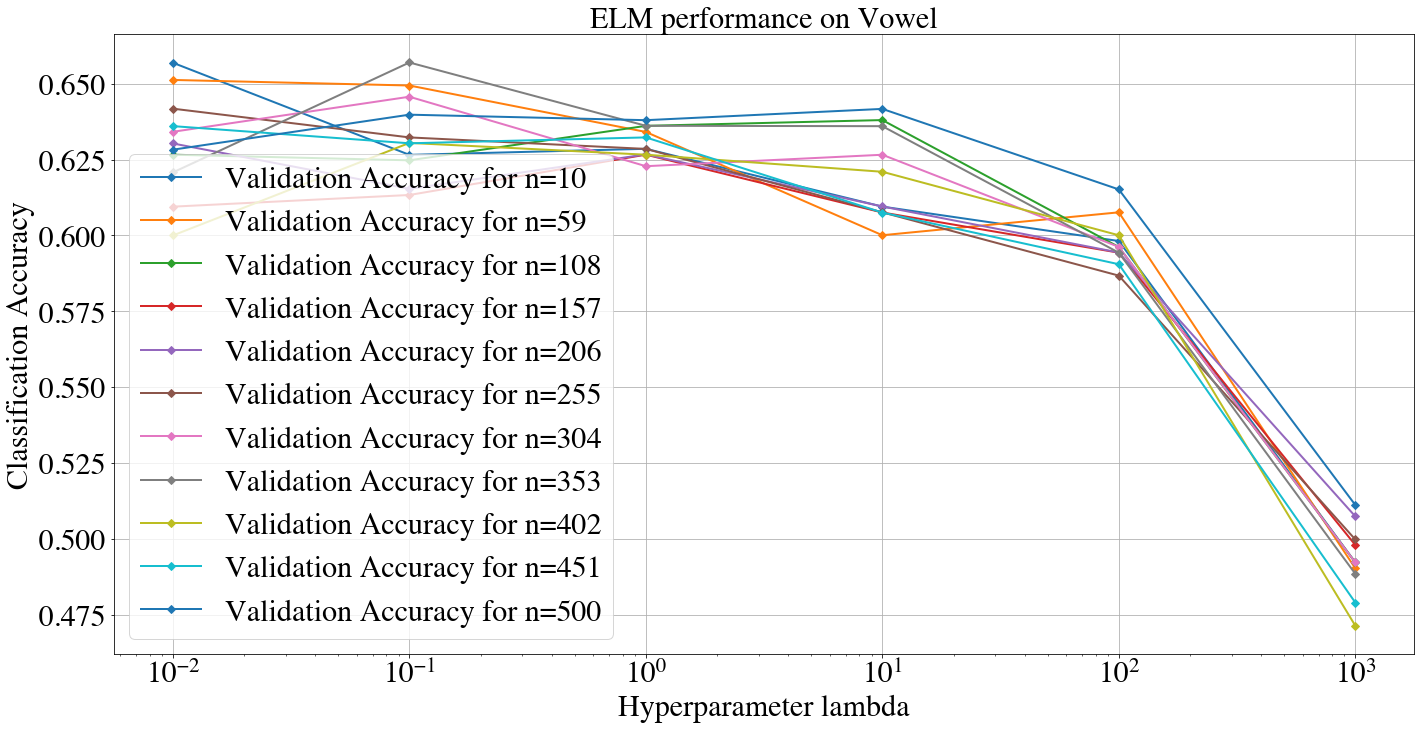

In [23]:
FontSize = 30
#csfont = {'fontname':'serif'}
plt.rc( 'font', size=30, family="Times" ) 
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for i, n in enumerate(n_arr):
    mean_score_lambda_arr = np.array([[m, p['lam']] for p,m in zip(grid.cv_results_['params'],grid.cv_results_['mean_test_score']) if p['n'] == n])
    plt.plot(mean_score_lambda_arr[:,1], mean_score_lambda_arr[:,0],  'D-', label="Validation Accuracy for n={}".format(n), linewidth=2)

ax.set_xscale('log')
plt.grid()
plt.xticks(fontsize=FontSize)
plt.yticks(fontsize=FontSize)
plt.tight_layout()
plt.legend(loc='best',fontsize=FontSize)
plt.xlabel("Hyperparameter lambda", fontsize=FontSize)
plt.ylabel("Classification Accuracy", fontsize=FontSize)
plt.title("ELM performance on Vowel", loc='center', fontsize=FontSize)
plt.show()

## Get the accuracy results on test data

In [24]:
from sklearn.metrics import classification_report

In [25]:
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = np.argmax(grid.predict(X_test.T) , axis=0).reshape((-1, 1))
# print classification report 
print(classification_report(np.argmax(T_test, axis=0), grid_predictions)) 

{'lam': 0.1, 'n': 353}
              precision    recall  f1-score   support

           0       1.00      0.52      0.69        42
           1       0.40      0.40      0.40        42
           2       0.42      0.31      0.36        42
           3       0.56      0.55      0.55        42
           4       0.24      0.33      0.28        42
           5       0.28      0.43      0.34        42
           6       0.11      0.10      0.10        42
           7       0.44      0.52      0.48        42
           8       0.38      0.48      0.42        42
           9       0.55      0.26      0.35        42
          10       0.20      0.21      0.21        42

    accuracy                           0.37       462
   macro avg       0.42      0.37      0.38       462
weighted avg       0.42      0.37      0.38       462



In [26]:
print(grid_predictions.shape, T_test.shape)

(462, 1) (11, 462)


## Using kernels with ELMs

### **Training ELM by using linear kernel**

We set the regularization hyperparameter alpha, and construct the kernel matrix for training and test data accordingly. In particular, the solution of the kernel method for a pair of $(\mathbf{y}_j,\mathbf{t}_j)$ can be written as 
\begin{align}
    \hat{\mathbf{t}}_j = \mathbf{T} (K + \alpha \mathbf{I})^{-1} k(\mathbf{y}_j),
\end{align}
where $\mathbf{K} \in \mathbb{R}^{J \times J}$ is the kernel matrix with elements $k_{ij}=\mathbf{k}(\mathbf{y}_i)^{'}\mathbf{k}(\mathbf{y}_j)$ for a given kernel $\mathbf{k}(\cdot)$. Note that $k(\mathbf{y}_j) \in \mathbb{R}^{J}$  is the product of sample $\mathbf{y}_j$ and training set with elements $k_{j}=\mathbf{k}(\mathbf{y}_i)^{'}\mathbf{k}(\mathbf{y}_j), \forall i = 1, \cdots, J$. In matrix form, we can write
\begin{align}
    \hat{\mathbf{T}}_{\text{test}} = \mathbf{T} (K + \alpha \mathbf{I})^{-1} K_{\text{test}},
\end{align}
where $K_{\text{test}} \in \mathbb{R}^{J \times J_{\text{test}}}$ is the kernel matrix between train and test samples for a given kernel $\mathbf{k}(\cdot)$. Now we apply a linear kernel $\mathbf{k}(\cdot)$ on the feature vectors of ELM in $\mathbf{Y}$ to predict the target.

Complete the code and
- Define the linear kernel $K(\mathbf{x}, \mathbf{y}) = \mathbf{x}^{\top}\mathbf{y}$
- Define the RBF kernel $K(\mathbf{x}, \mathbf{y}) = \exp\left(-\gamma\Vert\mathbf{x} - \mathbf{y}\Vert^2_2\right)$
- Compute $\mathbf{W}_{ker} = \mathbf{T} (K + \alpha \mathbf{I})^{-1}$

**NOTE:** We expect the performance of the linear kernel to be similar to what we obtained above using the LS-ELM.

In [27]:
class ELM_with_kernel(object):
    
    def __init__(self, n, alpha, P, kernel_type="linear", gamma=1.0):
        self.n = n
        self.alpha = alpha
        self.Ri = self.initialise_random_matrix(M=n, N=P)
        self.b = self.initialise_random_matrix(M=n, N=1)
        self.W_ker = None
        self.kernel_type = kernel_type
        self.gamma = gamma
        
    def linear_kernel(self, X, Y):
        return np.dot(X.T, Y)
        
    def rbf_kernel(self, X, Y):
        N1 = X.shape[1]
        N2 = Y.shape[1]
        n1sq = np.sum(np.square(X),axis=0)
        n2sq = np.sum(np.square(Y),axis=0)

        D = np.tile(n1sq, (N2, 1)).T + np.tile(n2sq, (N1, 1)) - 2 * np.dot(X.T, Y)  # the element i,j of this matrix are nothing but the individual distance of samples x_i and y_j meaning ||x_i - y_j||_2^2
        #C = np.tile(n1sq, (N1, 1)).T + np.tile(n1sq, (N1, 1)) - 2 * np.dot(X.T, X)  # the element i,j of this matrix are nothing but the individual distance of samples x_i and x_j meaning ||x_i - x_j||_2^2
        #temp = np.sum(C)/(N1*N1)    # temp represent the average distance of samples of X from each other. Note that C is zero on the diagonal.

        #K = np.exp(-D/temp)     # note that in this way we don't need to tune the value of temp
        
        K = np.exp(-D*self.gamma)
        return K
    
    def activation_function(self, Z):
        return np.maximum(0, Z)

    def initialise_random_matrix(self, M, N):
        return np.random.uniform(low = -1, high = 1, size = (M,N)) 
        #return A - np.mean(A)
        #return np.random.normal(0, 1, size=(M, N))
    
    def train(self, X, T):
        
        P = X.shape[0]
        N = X.shape[1]
        Zi = np.dot(self.Ri, X) + np.tile(self.b,(1,N))
        Yi = self.activation_function(Z=Zi)
        if self.kernel_type == "linear":
            self.W_ker = np.dot(T, np.linalg.inv(self.linear_kernel(Yi,Yi) + self.alpha * np.eye(N))).astype(np.float32)
        elif self.kernel_type == "gaussian":
            self.W_ker = np.dot(T, np.linalg.inv(self.rbf_kernel(Yi,Yi) + self.alpha * np.eye(N))).astype(np.float32)
    
    def evaluate(self, X_train, X_test):
        
        N_train = X_train.shape[1]
        N_test = X_test.shape[1]
        
        Zi_train = np.dot(self.Ri, X_train) + np.tile(self.b,(1,N_train))
        Yi_train = self.activation_function(Z=Zi_train)
        
        Zi_test = np.dot(self.Ri, X_test) + np.tile(self.b,(1,N_test))
        Yi_test = self.activation_function(Z=Zi_test)
        
        if self.kernel_type == "linear":
            K_test = self.linear_kernel(Yi_train, Yi_test)
        elif self.kernel_type == "gaussian":
            K_test = self.rbf_kernel(Yi_train, Yi_test)
        
        T_hat = np.dot(self.W_ker, K_test)
        return T_hat

In [28]:
def train_ELM_with_kernel(X_train, T_train, X_val=None, T_val=None, n=2000, alpha=1e2, kernel_type="linear", gamma=1.0):
    
    elm_net = ELM_with_kernel(n=n, alpha=alpha, P=X_train.shape[0], kernel_type=kernel_type)
    elm_net.train(X=X_train, T=T_train)
    T_hat_train = elm_net.evaluate(X_train=X_train, X_test=X_train)
    T_hat_val = elm_net.evaluate(X_train=X_train, X_test=X_val)
    acc_train = calculate_accuracy(T_hat_train, T_train)
    acc_val = calculate_accuracy(T_hat_val, T_val)
    
    return acc_train, acc_val, elm_net

### Train an ELM using Linear kernel, using the same parameters optimized earlier for $\lambda, n$

- Complete the code to train the ELM using a Linear kernel
- Complete the code to evaluate using the ELM trained using linear kernel on the test data

In [29]:
print("Hyper-parameters:")
print(grid.best_params_)

Hyper-parameters:
{'lam': 0.1, 'n': 353}


In [30]:
acc_train_linear_kernel_star, acc_val_linear_kernel_star, elm_net_linear_kernel_star = train_ELM_with_kernel(X_train, T_train, X_val, T_val, 
                                                                                           n=grid.best_params_['n'], 
                                                                                           alpha=grid.best_params_['lam'],
                                                                                           kernel_type="linear")

T_hat_test_linear_kernel = elm_net_linear_kernel_star.evaluate(X_train=X_train, X_test=X_test)
acc_test_linear_kernel_star = calculate_accuracy(T_hat_test_linear_kernel, T_test)
print("Optimized Lambda: {}, Acc_train: {}, Acc_val: {}, Acc_test: {}".format(grid.best_params_['lam'], 
                                                                              acc_train_linear_kernel_star, 
                                                                              acc_val_linear_kernel_star, 
                                                                              acc_test_linear_kernel_star))

Optimized Lambda: 0.1, Acc_train: 1.0, Acc_val: 0.9528301886792453, Acc_test: 0.341991341991342


### Training with Gaussian / RBF kernels using the same parameters optimized earlier for $\lambda, n$

- Complete the code to train the ELM using a Gaussian kernel
- Complete the code to evaluate using the ELM on the test data

**NOTE:** We expect an improvement in the classification accuracy using the RBF kernel

In [31]:
gamma = 1.5
acc_train_gaussian_kernel_star, acc_val_gaussian_kernel_star, elm_net_gaussian_kernel_star = train_ELM_with_kernel(X_train, T_train, X_val, T_val, 
                                                                                           n=grid.best_params_['n'], 
                                                                                           alpha=grid.best_params_['lam'],
                                                                                           kernel_type="gaussian",
                                                                                           gamma=gamma)

T_hat_test_gaussian_kernel = elm_net_gaussian_kernel_star.evaluate(X_train=X_train, X_test=X_test)
acc_test_gaussian_kernel_star = calculate_accuracy(T_hat_test_gaussian_kernel, T_test)
print("Optimized Lambda: {}, Gamma: {}, Acc_train: {}, Acc_val: {}, Acc_test: {}".format(grid.best_params_['lam'], gamma,
                                                                              acc_train_gaussian_kernel_star, 
                                                                              acc_val_gaussian_kernel_star, 
                                                                              acc_test_gaussian_kernel_star))

Optimized Lambda: 0.1, Gamma: 1.5, Acc_train: 1.0, Acc_val: 0.9905660377358491, Acc_test: 0.5735930735930735


### Bonus Question: In your opinion, why do we get an improvement using a RBF / gaussian kernel?

## Optional: Tuning the parameter $\gamma$ using GridSearchCV for RBF kernel

In [32]:
from sklearn.base import BaseEstimator

class ELM_with_kernel_estimator(BaseEstimator):
    
    def __init__(self, n=59, alpha=1.0, P=10, kernel_type="linear", gamma=1.0):
        self.n = n
        self.P = P
        self.alpha = alpha
        self.Ri = self.initialise_random_matrix(M=n, N=P)
        self.b = self.initialise_random_matrix(M=n, N=1)
        self.W_ker = None
        self.Yi_train = None
        self.kernel_type = kernel_type
        self.gamma = gamma
    
    def linear_kernel(self, X, Y):
        return np.dot(X.T, Y)
        
    def rbf_kernel(self, X, Y):
        N1 = X.shape[1]
        N2 = Y.shape[1]
        n1sq = np.sum(np.square(X),axis=0)
        n2sq = np.sum(np.square(Y),axis=0)

        D = np.tile(n1sq, (N2, 1)).T + np.tile(n2sq, (N1, 1)) - 2 * np.dot(X.T, Y)  # the element i,j of this matrix are nothing but the individual distance of samples x_i and y_j meaning ||x_i - y_j||_2^2
        #C = np.tile(n1sq, (N1, 1)).T + np.tile(n1sq, (N1, 1)) - 2 * np.dot(X.T, X)  # the element i,j of this matrix are nothing but the individual distance of samples x_i and x_j meaning ||x_i - x_j||_2^2
        #temp = np.sum(C)/(N1*N1)    # temp represent the average distance of samples of X from each other. Note that C is zero on the diagonal.

        #K = np.exp(-D/temp)     # note that in this way we don't need to tune the value of temp
        
        K = np.exp(-D/self.gamma)
        return K
    
    def activation_function(self, Z):
        return np.maximum(0, Z)

    def initialise_random_matrix(self, M, N):
        return np.random.uniform(low = -1, high = 1, size = (M,N)) 
        #return A - np.mean(A)
        #return np.random.normal(0, 1, size=(M, N))

    def LS(self, Y, T):
        """Solve the optimization problem as regularized least-squares"""
        P = Y.shape[0]
        W_ls = np.dot(np.dot(T,Y.T), np.linalg.inv(np.dot(Y,Y.T) + self.lam * np.eye(P))).astype(np.float32)
        return W_ls
    
    def fit(self, X, T):
        
        X, T = X.T, T.T
        P = X.shape[0]
        N = X.shape[1]
        Zi = np.dot(self.Ri, X) + np.tile(self.b,(1,N))
        Yi = self.activation_function(Z=Zi)
        if self.kernel_type == "linear":
            self.W_ker = np.dot(T, np.linalg.inv(self.linear_kernel(Yi,Yi) + self.alpha * np.eye(N))).astype(np.float32)
        elif self.kernel_type == "gaussian":
            self.W_ker = np.dot(T, np.linalg.inv(self.rbf_kernel(Yi,Yi) + self.alpha * np.eye(N))).astype(np.float32)
        self.Yi_train = Yi
        return self
        #T_hat = np.dot(self.W_ls, Yi)
        #return T_hat
    
    def predict(self, X_test):
        
        X_test = X_test.T
        #N_train = X_train.shape[1]
        N_test = X_test.shape[1]
        
        #Zi_train = np.dot(self.Ri, X_train) + np.tile(self.b,(1,N_train))
        #Yi_train = self.activation_function(Z=Zi_train)
        
        Zi_test = np.dot(self.Ri, X_test) + np.tile(self.b,(1,N_test))
        Yi_test = self.activation_function(Z=Zi_test)
        
        if self.kernel_type == "linear":
            K_test = self.linear_kernel(self.Yi_train, Yi_test)
        elif self.kernel_type == "gaussian":
            K_test = self.rbf_kernel(self.Yi_train, Yi_test)
        
        T_hat = np.dot(self.W_ker, K_test)
        return T_hat
    
    def score(self, X, T):
        
        T = np.transpose(T)
        T_hat = self.predict(X)
        Y = np.argmax(T_hat, axis=0)
        T = np.argmax(T, axis=0)
        
        accuracy = np.sum([Y == T]) / Y.shape[0]
        return accuracy
        

In [33]:
# You can set these parameter dictionaries as you like to search over a grid of parameters
param_grid_w_kernel = {'n': [grid.best_params_['n']],
                       'alpha': [grid.best_params_['lam']],
                       'P':[10],
                       'kernel_type':["gaussian"],
                       'gamma':np.linspace(0.1, 3.0, 30)
                      } 

In [34]:
grid_gaussk = GridSearchCV(ELM_with_kernel_estimator(), param_grid_w_kernel, refit = True, cv=5, verbose=3, n_jobs=4) 

# fitting the model for grid search 
grid_gaussk.fit(X_train_all.T, T_train_all.T) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=ELM_with_kernel_estimator(), n_jobs=4,
             param_grid={'P': [10], 'alpha': [0.1],
                         'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ]),
                         'kernel_type': ['gaussian'], 'n': [353]},
             verbose=3)

In [35]:
grid_gaussk.cv_results_['param_gamma'].data

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.7999999999999999,
       0.8999999999999999, 0.9999999999999999, 1.0999999999999999, 1.2,
       1.3, 1.4, 1.5, 1.5999999999999999, 1.7, 1.8, 1.9, 2.0,
       2.0999999999999996, 2.1999999999999997, 2.3, 2.4, 2.5, 2.6,
       2.6999999999999997, 2.8, 2.9, 3.0], dtype=object)

In [36]:
grid_gaussk.cv_results_['mean_test_score']

array([0.63259659, 0.66472597, 0.64742138, 0.66848158, 0.65135669,
       0.66652291, 0.69502246, 0.66467206, 0.68742138, 0.67590296,
       0.70247978, 0.67791554, 0.6608805 , 0.66460018, 0.66641509,
       0.68172507, 0.69502246, 0.69883199, 0.67216532, 0.68161725,
       0.67962264, 0.66445642, 0.66860737, 0.69690925, 0.65135669,
       0.65886792, 0.65890386, 0.68159928, 0.6872956 , 0.68927224])

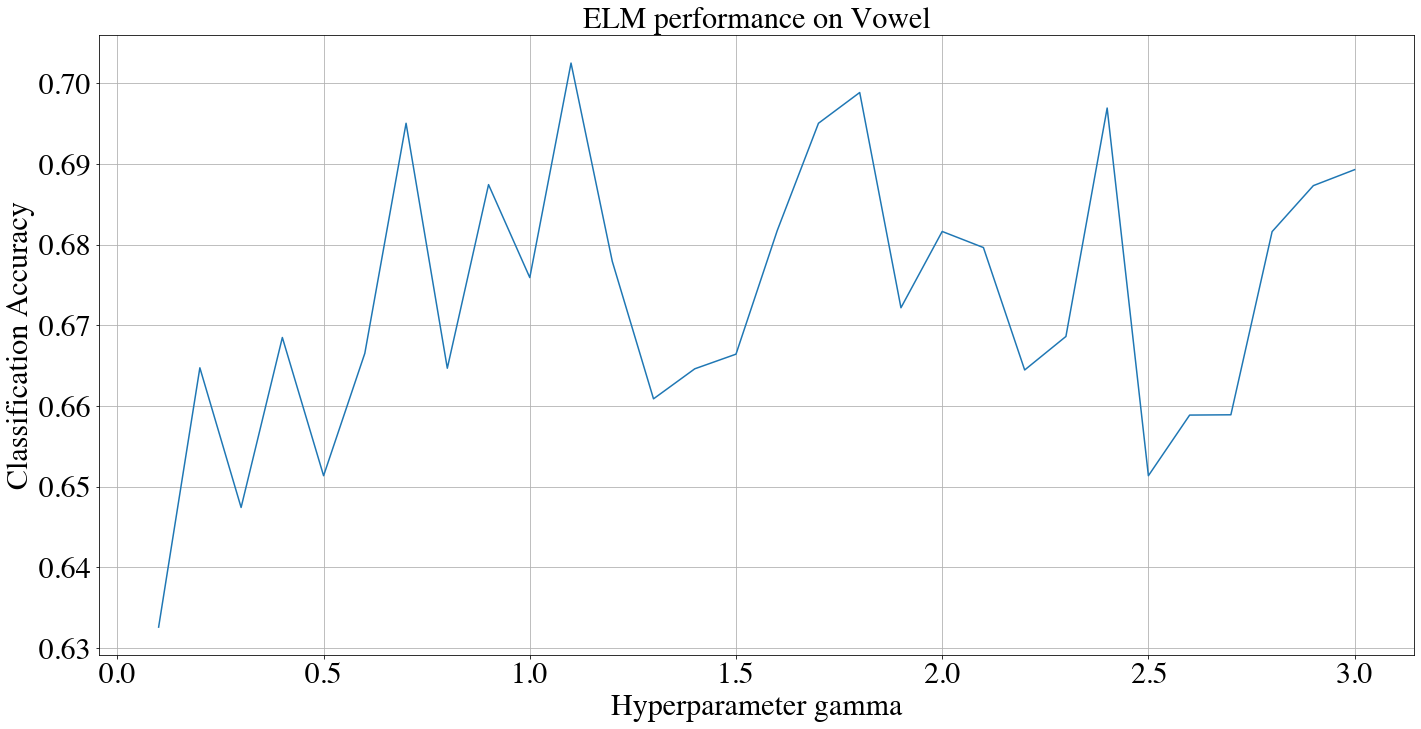

In [37]:
FontSize = 30
#csfont = {'fontname':'serif'}
plt.rc( 'font', size=30, family="Times" ) 
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)    
#ax.set_xscale('log')
plt.grid()
plt.plot(grid_gaussk.cv_results_['param_gamma'].data, grid_gaussk.cv_results_['mean_test_score'])
plt.xticks(fontsize=FontSize)
plt.yticks(fontsize=FontSize)
plt.tight_layout()
#plt.legend(loc='best',fontsize=FontSize)
plt.xlabel("Hyperparameter gamma", fontsize=FontSize)
plt.ylabel("Classification Accuracy", fontsize=FontSize)
plt.title("ELM performance on Vowel", loc='center', fontsize=FontSize)
plt.show()

In [38]:
grid_gaussk.best_params_

{'P': 10,
 'alpha': 0.1,
 'gamma': 1.0999999999999999,
 'kernel_type': 'gaussian',
 'n': 353}

In [39]:
acc_train_gaussian_kernel_star, acc_val_gaussian_kernel_star, elm_net_gaussian_kernel_star = train_ELM_with_kernel(X_train, T_train, X_val, T_val, 
                                                                                           n=grid.best_params_['n'], 
                                                                                           alpha=grid.best_params_['lam'],
                                                                                           kernel_type="gaussian",
                                                                                           gamma=grid_gaussk.best_params_['gamma'])

T_hat_test_gaussian_kernel = elm_net_gaussian_kernel_star.evaluate(X_train=X_train, X_test=X_test)
acc_test_gaussian_kernel_star = calculate_accuracy(T_hat_test_gaussian_kernel, T_test)
print("Optimized Lambda: {}, Gamma: {}, Acc_train: {}, Acc_val: {}, Acc_test: {}".format(grid.best_params_['lam'], 
                                                                              grid_gaussk.best_params_['gamma'],
                                                                              acc_train_gaussian_kernel_star, 
                                                                              acc_val_gaussian_kernel_star, 
                                                                              acc_test_gaussian_kernel_star))

Optimized Lambda: 0.1, Gamma: 1.0999999999999999, Acc_train: 1.0, Acc_val: 1.0, Acc_test: 0.5757575757575758
[CV 4/5] END ....................lam=0.01, n=10;, score=0.610 total time=   1.1s
[CV 3/5] END ....................lam=0.01, n=59;, score=0.821 total time=   1.0s
[CV 5/5] END ....................lam=0.01, n=59;, score=0.524 total time=   0.9s
[CV 5/5] END ...................lam=0.01, n=108;, score=0.448 total time=   0.9s
[CV 3/5] END ...................lam=0.01, n=157;, score=0.792 total time=   0.9s
[CV 2/5] END ...................lam=0.01, n=206;, score=0.613 total time=   0.9s
[CV 1/5] END ...................lam=0.01, n=255;, score=0.679 total time=   0.9s
[CV 1/5] END ...................lam=0.01, n=304;, score=0.651 total time=   0.9s
[CV 5/5] END ...................lam=0.01, n=304;, score=0.476 total time=   0.9s
[CV 4/5] END ...................lam=0.01, n=353;, score=0.590 total time=   0.9s
[CV 3/5] END ...................lam=0.01, n=402;, score=0.811 total time=   0.9s


[CV 2/5] END ....................lam=0.01, n=10;, score=0.642 total time=   1.1s
[CV 2/5] END ....................lam=0.01, n=59;, score=0.623 total time=   1.0s
[CV 4/5] END ....................lam=0.01, n=59;, score=0.638 total time=   0.9s
[CV 4/5] END ...................lam=0.01, n=108;, score=0.657 total time=   0.9s
[CV 4/5] END ...................lam=0.01, n=157;, score=0.619 total time=   0.9s
[CV 3/5] END ...................lam=0.01, n=206;, score=0.849 total time=   0.9s
[CV 2/5] END ...................lam=0.01, n=255;, score=0.585 total time=   0.9s
[CV 5/5] END ...................lam=0.01, n=255;, score=0.533 total time=   0.9s
[CV 4/5] END ...................lam=0.01, n=304;, score=0.629 total time=   0.9s
[CV 3/5] END ...................lam=0.01, n=353;, score=0.792 total time=   0.9s
[CV 1/5] END ...................lam=0.01, n=402;, score=0.594 total time=   0.9s
[CV 5/5] END ...................lam=0.01, n=402;, score=0.438 total time=   0.9s
[CV 4/5] END ...............